## Set up

Set Filepaths
Import packages



In [1]:
# set filepaths
path_to_raw = '../data/raw/'

# import packages - general
import numpy as np
import pandas as pd

# import packages - geospatial
import xarray as xr

# import packages - plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Read in data

In [2]:
# set datafiles
#datafiles = ['era5_mslp_sst.nc', 'era5_sp_sst.nc','era5_gph.nc','era5_t2.nc']
#datafiles = ['era5_gph.nc','era5_t2.nc']
#datafiles = ['era5_mslp_sst.nc', 'era5_gph.nc']
datafiles = ['era5_gph.nc','era5_sst_mslp.nc']

# read in datafiles, combine into one dataset
for i in range(len(datafiles)):
    print("Loading datafile: ", datafiles[i])

    # if it's the first file, make it a dataset. Else, just add it on
    if i==0:
        print("    Reading")
        ds = xr.open_dataset(path_to_raw + datafiles[i],engine='netcdf4')
        if 'valid_time' in ds.dims:
            print("    Renaming Time Dimension")
            ds = ds.rename_dims({'valid_time':'time'})
            ds = ds.rename_vars({'valid_time':'time'})

        # # remove any times beofre 1940
        # print("    Removing Times Before 1940")
        # ds = ds.sel(time=slice('1940-01-01',None))

        # coarsen the data
        print("    Coarsening")
        #ds = ds.coarsen(latitude=2, longitude=2, boundary="trim").mean()

    else:

        # if the time dimension is called 'valid time', change it to 'time'
        print("    Reading")
        ds2 = xr.open_dataset(path_to_raw + datafiles[i],engine='netcdf4')

        if 'valid_time' in ds2.dims:
            print("    Renaming Time Dimension")
            ds2 = ds2.rename_dims({'valid_time':'time'})
            ds2 = ds2.rename_vars({'valid_time':'time'})

        # # remove any times beofre 1970
        # print("    Removing Times Before 1970")
        # ds2 = ds2.sel(time=slice('1970-01-01',None))

        # coarsen the data
        print("    Coarsening")
        #ds2 = ds2.coarsen(latitude=2, longitude=2, boundary="trim").mean()

        print("    Merging")
        ds = xr.merge([ds,ds2])
    
    # delete 


Loading datafile:  era5_gph.nc
    Reading
    Renaming Time Dimension
    Coarsening
Loading datafile:  era5_sst_mslp.nc
    Reading
    Renaming Time Dimension
    Coarsening
    Merging


In [3]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:         (time: 996, pressure_level: 1, latitude: 721,
                     longitude: 1440)
Coordinates:
    number          int64 8B 0
  * time            (time) datetime64[ns] 8kB 1940-01-01 ... 2022-12-01
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver          (time) <U4 16kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    z               (time, pressure_level, latitude, longitude) float32 4GB ...
    sst             (time, latitude, longitude) float32 4GB ...
    msl             (time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [4]:
# print min/max values in the time, latitude, and longitude dimensions for each variable
for var in ds.data_vars:
    print(var)
    print(ds[var].min(['time','latitude','longitude']).values)
    print(ds[var].max(['time','latitude','longitude']).values)
    print('\n')

z
[45478.727]
[58535.56]


sst
269.12866
309.6814


msl
95671.375
104965.125




In [5]:
# check we've got what we think we should
ds.head()

<xarray.Dataset> Size: 2kB
Dimensions:         (time: 5, pressure_level: 1, latitude: 5, longitude: 5)
Coordinates:
    number          int64 8B 0
  * time            (time) datetime64[ns] 40B 1940-01-01 ... 1940-05-01
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 40B 90.0 89.75 89.5 89.25 89.0
  * longitude       (longitude) float64 40B 0.0 0.25 0.5 0.75 1.0
    expver          (time) <U4 80B '0001' '0001' '0001' '0001' '0001'
Data variables:
    z               (time, pressure_level, latitude, longitude) float32 500B ...
    sst             (time, latitude, longitude) float32 500B 271.5 ... 271.5
    msl             (time, latitude, longitude) float32 500B 1.027e+05 ... 1....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

## Clean Data - Check for nan values\

There are no nan vlaues except in the sst field. These likely represent temperatures over land. No additional cleaning is needed here.

In [6]:
# takes a while, so I've included a toggle to swtich this on and off
if False:
    # Check for NaN values in the specified fields
    nan_sst = ds['sst'].isnull().sum().item()
    nan_msl = ds['msl'].isnull().sum().item()
    nan_sp = ds['sp'].isnull().sum().item()
    nan_z = ds['z'].isnull().sum().item()

    print(f"NaN values in 'sst': {nan_sst}")
    print(f"NaN values in 'msl': {nan_msl}")
    print(f"NaN values in 'sp': {nan_sp}")
    print(f"NaN values in 'z': {nan_z}")

## Clean Data - Remove lakes and non-ocean water from SST dataset

I don't want to include these when thinking about ocean temperature.

Here I use the GEBCO bathymetry dataset to mask out the land areas.
 - First, I read in the dataset
 - Next I resample to match the spatial resolution of the ERA5 data in my xarray ds
- Next, I apply a filter for bathymetry below sea level (-5m) to identify ocean areas.
 - Next, I set the SST field to nan for all values where the GEBCO file is deeper than the -5m threshold

Regrettably, the resolution of this seems to be too large for me to handle on my own computer. I think useing the ERA5 dataset will be ideal, but the site is currently down (see my Download_Data.ipynb). For now, I impliment a lower-accruacy solution below. There are still some issues that creap through in this approach, so a better solution is needed in the long term.

In [7]:
# This works in theory (I think), but is VERY slow due to the super high resolution gebco dataset.
if False:

    # Read in GEBCO bathymetry dataset
    gebco_path = path_to_raw + 'GEBCO_2024.nc'
    gebco_ds = xr.open_dataset(gebco_path)

    # switch gebco_ds longitude values which are less than 0 to be 0-360
    #ds2 = gebco_ds.assign_coords(lon=(gebco_ds.coords['lon'].values + 360)%360)
    gebco_ds['lon'] = (gebco_ds['lon'] + 360) % 360
    gebco_ds = gebco_ds.sortby('lon')

    # resample to era5 grid
    elevation = gebco_ds.interp(lat=ds['latitude'], lon=ds['longitude'], method='nearest')

    # Set the SST field to NaN for all values where the GEBCO file is deeper than the -5m threshold
    ocean_mask = elevation < -5
    ds['sst'] = ds['sst'].where(ocean_mask, other=np.nan)


In [8]:
# for now, just using a lower resolution solution
from global_land_mask import globe

# Apply the is_ocean function to the entire xarray dataset
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

# Create a mask for ocean points
print('making mask')
ocean_mask = np.array([[globe.is_ocean(lat, lon) for lon in ((longitudes + 180) % 360) - 180] for lat in latitudes])

# Apply the mask to the SST field
print('applying mask')
ds['sst'] = ds['sst'].where(ocean_mask, other=np.nan)

making mask
applying mask


## Plot the SST and SP data to check
Looks like we successfully removed the lakes etc! I think this system isn't perfect (would love to get ERA5 or gebco data to work), but this is sufficent for now.

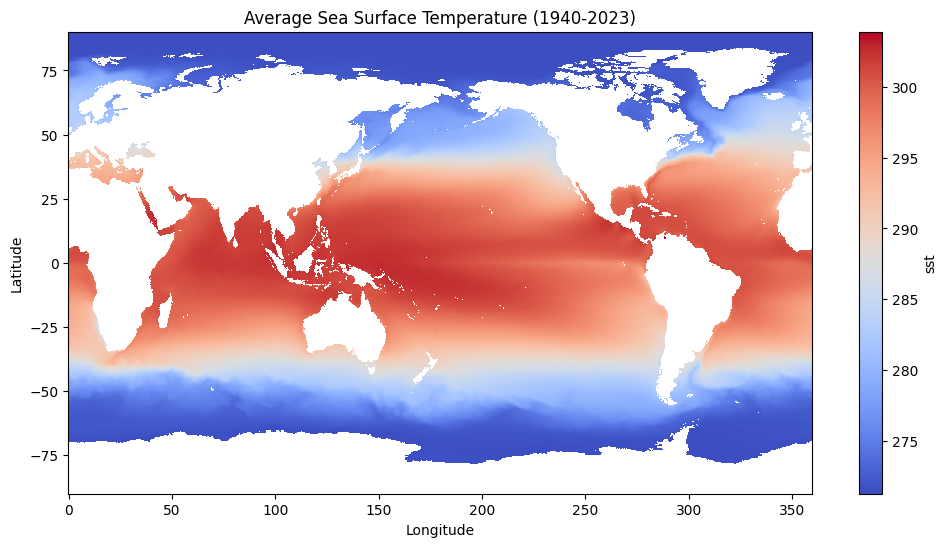

In [9]:
# Plot SSTs to confirm the above approach worked - it does! No more lakes!

# Calculate the average SST over the entire time period
sst_mean = ds.sst.mean(dim='time')

# Plot the global map of the average SST
plt.figure(figsize=(12, 6))
sst_mean.plot(cmap='coolwarm')
plt.title('Average Sea Surface Temperature (1940-2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

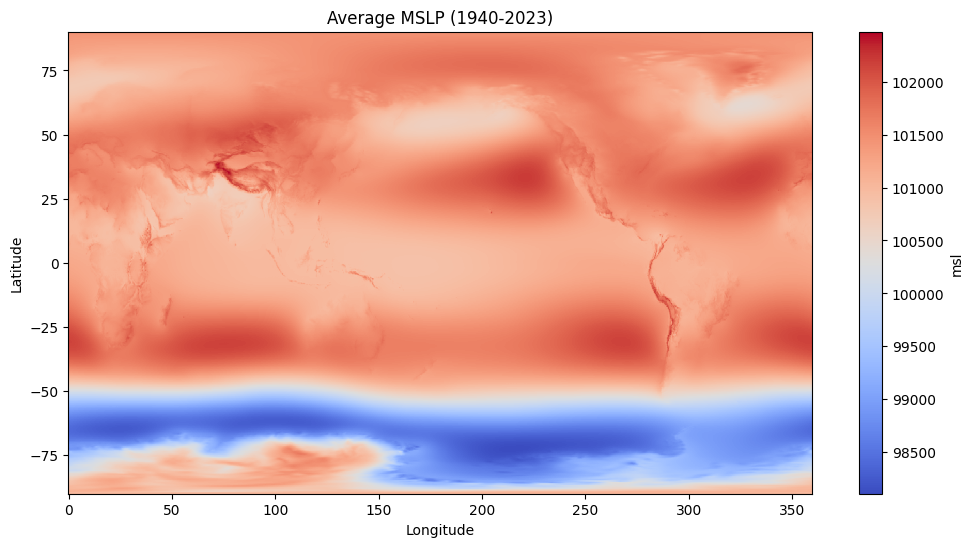

In [10]:
# Calculate the average MSL over the entire time period
msl_mean = ds.msl.mean(dim='time')

# Plot the global map of the average SST
plt.figure(figsize=(12, 6))
msl_mean.plot(cmap='coolwarm')
plt.title('Average MSLP (1940-2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

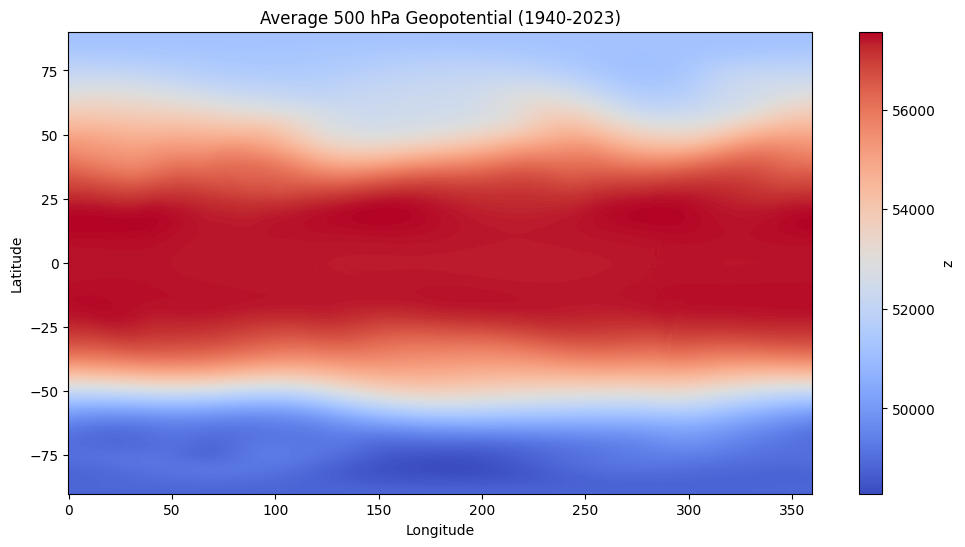

In [11]:
# Calculate the average 500hPa Height over the entire time period
z_mean = ds.z.mean(dim='time')

# Plot the global map of the average SST
plt.figure(figsize=(12, 6))
z_mean.plot(cmap='coolwarm')
plt.title('Average 500 hPa Geopotential (1940-2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Save data now that it's Cleaned

In [12]:
# save to file - getting a weird permission eror, so saving to home directory for now
#ds.to_netcdf('../data/cleaned/era5.nc')
ds.to_netcdf('~/era5.nc')